In [ ]:
!pip install rasterio
!pip install rioxarray
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 51.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 14.1 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=e41af4b6aedcda8e5b2d3448f9a0394274be1a796b8128a3f22203c4cf5a1132
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.8 MB/s 
     |████████████████████████████████| 16.7 MB 46.6 MB

In [ ]:
import rasterio
import geopandas as gpd
import rioxarray
from rasterio.plot import show
from pyproj import CRS
from google.colab import drive
import os
import numpy as np
import math
import fiona
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import shapely
from fiona.crs import from_epsg
from rasterio.features import rasterize
import cv2
from PIL import Image
import pickle
import random
import colorsys

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/ASU - Zhiang/Projects/instance segmentation/')
os.listdir()

Mounted at /content/drive


['data',
 'instance_registration.ipynb',
 'TGRS',
 'instance_registration_IoU.ipynb',
 'random_ellipse_shapefile_generation.ipynb',
 'instance_registration_IoU_all_adjacents.ipynb',
 'overlap.png',
 'tile_splitting.ipynb']

# Tile splitter

In [ ]:
class Tile_Splitter(object):
    def __init__(self, tif_path, shapefile_path, tile_size, save_dir, crs, area_x1, area_y1, area_x2, area_y2, overlap, keep_instance_tif):
        """
        tif_path: path of the tif file to be split. None if only shapefile is to be split.
        shapefile_path: path of the shapefile to be split
        tile_size: in meters
        save_dir: path of the split shapefiles to be saved
        crs: coordinate reference system (e.g., from fiona.crs import from_epsg)
        area_x1: area small coordinate x in meters. Not required if tif_path is not None.
        area_y1: area small coordinate y in meters.
        area_x2: area large coordinate x in meters.
        area_y2: area large coordinate y in meters.
        overlap: overlap between tiles in meters.
        keep_instance_tif: it will only save tif files where there are instances if True. Otherwise, it saves all tif tiles. 
        """
        if tif_path is not None:
          assert os.path.isfile(tif_path)
        assert os.path.isfile(shapefile_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.tile_dir = save_dir
        self.tile_size = tile_size
        if tif_path is not None:
          self.tif = rioxarray.open_rasterio(tif_path)
          self.x1, self.y1, self.x2, self.y2 = self.tif.rio.bounds()
          self.crs = self.tif.rio.crs
        else:
          self.tif = None
          self.x1, self.y1, self.x2, self.y2 = area_x1, area_y1, area_x2, area_y2
          self.crs = crs
        self.instances_shp = gpd.read_file(shapefile_path).explode()
        self.tiles = {}
        self.overlap = overlap
        self.I_max = int((self.x2 - self.x1) / (self.tile_size - self.overlap))
        self.J_max = int((self.y2 - self.y1) / (self.tile_size - self.overlap))
        self.keep_instance_tif = keep_instance_tif

    def split(self):
        for id, instance in enumerate(self.instances_shp['geometry']):
            bbox = instance.bounds
            tile_indices = self._calculate_tile_indices(bbox)
            # instance is within one tile
            if tile_indices.shape[0] == 1:
                tile_index = tile_indices[0]
                if ((tile_index[0] == 0) | (tile_index[0] == self.I_max)) | ((tile_index[1] == 0) | (tile_index[1] == self.J_max)):
                    tile_poly = self._calculate_tile_polygon(tile_index)
                    instance_poly = self._extract_instance_polygon(instance)
                    poly = tile_poly.intersection(instance_poly)
                    self._add_instance(poly, tile_index, str(id))   ############################################################
                else:
                    instance_poly = self._extract_instance_polygon(instance)
                    self._add_instance(instance_poly, tile_indices[0], str(id))
                continue
            # instance is on multiple tiles
            for tile_index in self._calculate_tile_indices(bbox):
                tile_poly = self._calculate_tile_polygon(tile_index)
                instance_poly = self._extract_instance_polygon(instance)
                if not tile_poly.intersects(instance_poly):
                    continue
                poly = tile_poly.intersection(instance_poly)
                self._add_instance(poly, tile_index, str(id))

        self._create_tile_shapefiles()
        if self.tif is not None:
          self._clip_tiff_tiles()
    
    def _clip_tiff_tiles(self):
        if self.keep_instance_tif:
            for tile_index in self.tiles:
                i, j = tile_index
                x1 = self.x1 + i*(self.tile_size - self.overlap)
                x2 = self.x1 + i*(self.tile_size - self.overlap) + self.tile_size
                y1 = self.y1 + j*(self.tile_size - self.overlap)
                y2 = self.y1 + j*(self.tile_size - self.overlap) + self.tile_size
                clipped_tif = self.tif.rio.clip_box(
                    minx=x1,
                    miny=y1,
                    maxx=x2,
                    maxy=y2,
                )
                f = os.path.join(self.tile_dir, "{x}_{y}.tif".format(x=tile_index[0], y=tile_index[1]))
                clipped_tif.rio.to_raster(f)
                print(f)
        else:
            coords = np.array(list(ts.tiles.keys()))
          
            X = np.max(coords[:, 0])
            Y = np.max(coords[:, 1])
            for i in range(X):
                for j in range(Y):
                    x1 = self.x1 + i*(self.tile_size - self.overlap)
                    x2 = self.x1 + i*(self.tile_size - self.overlap) + self.tile_size
                    y1 = self.y1 + j*(self.tile_size - self.overlap)
                    y2 = self.y1 + j*(self.tile_size - self.overlap) + self.tile_size
                    clipped_tif = self.tif.rio.clip_box(
                        minx=x1,
                        miny=y1,
                        maxx=x2,
                        maxy=y2,
                    )
                    f = os.path.join(self.tile_dir, "{x}_{y}.tif".format(x=i, y=j))
                    clipped_tif.rio.to_raster(f)
                    print(f)

    def _create_tile_shapefiles(self):
        for tile_index in self.tiles:
            instance_polys = self.tiles[tile_index]
            schema = {'geometry':'Polygon', 'properties':[('id','str')]}
            f = os.path.join(self.tile_dir, "{x}_{y}.shp".format(x=tile_index[0], y=tile_index[1]))
            print(f)
            polyShp = fiona.open(f, mode='w', driver='ESRI Shapefile', schema = schema, crs = self.crs)
            for instance_poly, id in instance_polys:
                if isinstance(instance_poly, shapely.geometry.multipolygon.MultiPolygon):
                    for ins_poly in instance_poly:
                        x,y = ins_poly.exterior.coords.xy
                        xy = np.asarray((x,y)).transpose()
                        rowDict = {'geometry' : {'type':'Polygon', 'coordinates': [xy]}, 'properties': {'id': id}}
                        polyShp.write(rowDict)
                    continue
                x,y = instance_poly.exterior.coords.xy
                xy = np.asarray((x,y)).transpose()
                rowDict = {'geometry' : {'type':'Polygon', 'coordinates': [xy]}, 'properties': {'id': id}}
                polyShp.write(rowDict)

            polyShp.close()
            
    def _add_instance(self, instance_poly, tile_index, id):
        tile_index = tuple(tile_index)
        result = self.tiles.get(tile_index, False)
        if not result:
            self.tiles[tile_index] = [(instance_poly, id)]
        else:
            self.tiles[tile_index].append((instance_poly, id))

    def _calculate_tile_indices(self, bbox):
        x1, y1, x2, y2 = bbox
        pt0 = (x1, y1)
        pt1 = (x1, y2)
        pt2 = (x2, y1)
        pt3 = (x2, y2)
        pts = (pt0, pt1, pt2, pt3)
        tile_index = []
        # find the ranges of i and j
        i_min = 1e100
        i_max = -1
        j_min = 1e100
        j_max = -1
        for pt in pts:
            i = int((pt[0] - self.x1)/(self.tile_size - self.overlap))
            if i > i_max:
                i_max = i
            if ((pt[0] - self.x1) % (self.tile_size - self.overlap)) < self.overlap:
              i = i - 1
            if i < i_min:
                i_min = i

            j = int((pt[1] - self.y1)/(self.tile_size - self.overlap))
            if j > j_max:
                j_max = j
            if ((pt[1] - self.y1) % (self.tile_size - self.overlap)) < self.overlap:
              j = j - 1
            if j < j_min:
                j_min = j

        if i_min < 0: i_min = 0
        if i_max > self.I_max: i_max = self.I_max
        if j_min < 0: j_min = 0
        if j_max > self.J_max: j_max = self.J_max

        for i in range(i_min, i_max+1):
            for j in range(j_min, j_max+1):
                tile_index.append((i, j))

        tile_index = np.asarray(tile_index)
        return np.unique(tile_index, axis=0)

    def _calculate_tile_polygon(self, tile_index):
        i, j = tile_index
        pt0 = (self.x1 + i*(self.tile_size-self.overlap), self.y1 + j*(self.tile_size-self.overlap))
        pt1 = (self.x1 + i*(self.tile_size-self.overlap) + self.tile_size, self.y1 + j*(self.tile_size-self.overlap))
        pt2 = (self.x1 + i*(self.tile_size-self.overlap) + self.tile_size, self.y1 + j*(self.tile_size-self.overlap) + self.tile_size)
        pt3 = (self.x1 + i*(self.tile_size-self.overlap), self.y1 + j*(self.tile_size-self.overlap) + self.tile_size)
        return Polygon((pt0, pt1, pt2, pt3))

    def _extract_instance_polygon(self, instance):
        XYZ = []
        for xyz in instance.boundary.coords:
            XYZ.append(xyz)

        XYZ = np.asarray(XYZ)
        XY = XYZ[:, :2]
        return Polygon(XY)

    def _initiate_tile_shapefiles(self):
        x_N = math.ceil((self.x2 - self.x1)/(self.tile_size - self.overlap))
        y_N = math.ceil((self.y2 - self.y1)/(self.tile_size - self.overlap))
        for i in range(x_N):
            for j in range(y_N):
                schema = {'geometry':'Polygon', 'properties':[('name','str')]}
                f = os.path.join(self.tile_dir, "{x}_{y}.shp".format(x=i, y=j))
                polyShp = fiona.open(f, mode='w', driver='ESRI Shapefile', schema = schema, crs = self.crs)
                
                pt0 = (self.x1 + i*(self.tile_size-self.overlap), self.y1 + j*(self.tile_size-self.overlap))
                pt1 = (self.x1 + i*(self.tile_size-self.overlap) + self.tile_size, self.y1 + j*(self.tile_size-self.overlap))
                pt2 = (self.x1 + i*(self.tile_size-self.overlap) + self.tile_size, self.y1 + j*(self.tile_size-self.overlap) + self.tile_size)
                pt3 = (self.x1 + i*(self.tile_size-self.overlap), self.y1 + j*(self.tile_size-self.overlap) + self.tile_size)
                tile = [[pt0, pt1, pt2, pt3]]
                rowDict = {'geometry' : {'type':'Polygon', 'coordinates': tile}, 'properties': {'name': 'tile'}}
                polyShp.write(rowDict)

                polyShp.close()
                
                

# Split shapefile

In [ ]:
epsg = 32611  # WGS 84 / UTM zone 11N
crs = from_epsg(epsg)

#!rm data/random_generation/split/*

test_config = {'tif_path': None, 
               'shapefile_path': "data/random_generation/random_40_3.shp", 
               'tile_size':10, 
               'save_dir': "data/random_generation/split", 
               'crs':crs, 
               'area_x1':0, 
               'area_y1':0, 
               'area_x2':30, # this should be modified for different shapefiles
               'area_y2':30, 
               'overlap':1,
               'keep_instance_tif': True}

ts = Tile_Splitter(**test_config)

ts.split()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


data/random_generation/split/3_2.shp
data/random_generation/split/2_2.shp
data/random_generation/split/2_3.shp
data/random_generation/split/2_0.shp
data/random_generation/split/2_1.shp
data/random_generation/split/1_0.shp
data/random_generation/split/3_1.shp
data/random_generation/split/0_2.shp
data/random_generation/split/0_3.shp
data/random_generation/split/0_1.shp
data/random_generation/split/0_0.shp
data/random_generation/split/1_2.shp
data/random_generation/split/1_1.shp
data/random_generation/split/1_3.shp
data/random_generation/split/3_3.shp
data/random_generation/split/3_0.shp


# Split shapefile and tiff files

In [ ]:
epsg = 32611  # WGS 84 / UTM zone 11N
crs = from_epsg(epsg)

!rm data/random_generation/split/*

test_config = {'tif_path': 'data/random_generation/random_400_3.tif', 
               'shapefile_path': "data/random_generation/random_400_3.shp", 
               'tile_size':10, 
               'save_dir': "data/random_generation/split", 
               'crs':crs, 
               'area_x1':0, 
               'area_y1':0, 
               'area_x2':30, # this should be modified for different shapefiles
               'area_y2':30, 
               'overlap':1,
               'keep_instance_tif': True}

ts = Tile_Splitter(**test_config)

ts.split()

In [ ]:
# granite dells

crs = None


!rm data/rock/split/*

test_config = {'tif_path': 'data/rock/gd_spring_2.tif', 
               'shapefile_path': "data/rock/rock shapefile.shp", 
               'tile_size':10, 
               'save_dir': "data/rock/split", 
               'crs':crs, 
               'area_x1':0, 
               'area_y1':0, 
               'area_x2':30, # this should be modified for different shapefiles
               'area_y2':30, 
               'overlap':1,
               'keep_instance_tif': False}

ts = Tile_Splitter(**test_config)

ts.split()

rm: cannot remove 'data/rock/split/*': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


data/rock/split/25_12.shp
data/rock/split/25_13.shp
data/rock/split/26_11.shp
data/rock/split/23_11.shp
data/rock/split/24_11.shp
data/rock/split/23_10.shp
data/rock/split/21_12.shp


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


data/rock/split/22_12.shp
data/rock/split/23_9.shp
data/rock/split/24_9.shp
data/rock/split/24_10.shp
data/rock/split/24_13.shp
data/rock/split/22_13.shp
data/rock/split/23_13.shp
data/rock/split/21_13.shp
data/rock/split/20_13.shp
data/rock/split/20_12.shp
data/rock/split/12_13.shp
data/rock/split/13_13.shp
data/rock/split/12_14.shp
data/rock/split/13_14.shp
data/rock/split/11_13.shp
data/rock/split/11_14.shp
data/rock/split/11_15.shp
data/rock/split/10_14.shp
data/rock/split/10_15.shp
data/rock/split/9_14.shp
data/rock/split/8_14.shp
data/rock/split/9_15.shp
data/rock/split/9_16.shp
data/rock/split/10_16.shp
data/rock/split/10_13.shp
data/rock/split/12_12.shp
data/rock/split/13_12.shp
data/rock/split/14_12.shp
data/rock/split/14_11.shp
data/rock/split/13_11.shp
data/rock/split/14_15.shp
data/rock/split/16_11.shp
data/rock/split/10_12.shp
data/rock/split/11_12.shp
data/rock/split/7_18.shp
data/rock/split/7_17.shp
data/rock/split/8_18.shp
data/rock/split/6_18.shp
data/rock/split/4_17.s

# Crop entire area/remove edges

In [ ]:
epsg = 32611  # WGS 84 / UTM zone 11N
crs = from_epsg(epsg)

test_config = {'tif_path': None, 
               'shapefile_path': "data/random_generation/random_400_3.shp", 
               'tile_size':40, 
               'save_dir': "data/random_generation/", 
               'crs':crs, 
               'area_x1':0, 
               'area_y1':0, 
               'area_x2':30, 
               'area_y2':30, 
               'overlap':0,
               'keep_instance_tif': True}

ts = Tile_Splitter(**test_config)

ts.split()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


data/random_generation/0_0.shp


# Generate fake pickle files

In [ ]:
def get_coords_from_file_name(f):
    coords = f.split('.')[0].split('/')[-1].split('_')
    return (int(coords[0]), int(coords[1]))

class Dataset(object):
    def __init__(self, pixel_size, split_path, input_channel=(0,1,2)):
        data_path = os.path.realpath(split_path)
        self.data_files = [os.path.join(data_path, data_file) for data_file in os.listdir(split_path) if data_file.endswith('.tif')]
        coords = [get_coords_from_file_name(f) for f in self.data_files]
        coords = np.array(coords)
        self.X = np.max(coords[:, 0])
        self.Y = np.max(coords[:, 1])
        x_edge_file = os.path.join(data_path, '{i}_0.tif'.format(i=self.X))
        y_edge_file = os.path.join(data_path, '0_{i}.tif'.format(i=self.Y))
        x_edge_tif = rasterio.open(x_edge_file)
        y_edge_tif = rasterio.open(y_edge_file)
        h, w = x_edge_tif.shape
        self.x_edge_scaling = pixel_size/h
        h, w = y_edge_tif.shape
        self.y_edge_scaling = pixel_size/w

        self.pixel_size = pixel_size
        self.input_channel = input_channel

    def __getitem__(self, idx):
        
        data_path = self.data_files[idx]
        coords = get_coords_from_file_name(data_path)
        
        image = np.asarray(Image.open(data_path).resize((self.pixel_size, self.pixel_size)))

        if len(self.input_channel) != 1:
            image = image[:,:,self.input_channel]
        
        shp_path = data_path[:-3]+'shp'
        if not os.path.isfile(shp_path):
            return image, None
        
        shp = gpd.read_file(shp_path)
        masks = []
        boxes = []
        id_strs = []
        N, _ = shp.shape
        for i in range(N):
            poly = shp['geometry'][i]
            id_str = shp['id'][i]
            if poly is None:
                continue
            tif = rasterio.open(data_path)
            p = self._poly_from_utm(poly, tif.meta['transform'])
            mask = np.zeros((self.pixel_size, self.pixel_size))
            raster_tif = rasterize([p], (tif.height, tif.width))
            if (abs(tif.width - self.pixel_size) < 2) & (abs(tif.height - self.pixel_size) < 2):
                mask = cv2.resize(raster_tif, dsize=(self.pixel_size, self.pixel_size), interpolation=cv2.INTER_LINEAR)
            else:
              if (coords[0] == self.X) & (coords[1] == self.Y):
                  tmp = cv2.resize(raster_tif, (int(tif.width*self.x_edge_scaling), int(tif.height*self.y_edge_scaling)))
                  mask[-int(tif.height*self.y_edge_scaling):, : int(tif.width*self.x_edge_scaling)] = tmp
              elif coords[0] == self.X:
                  tmp = cv2.resize(raster_tif, (int(tif.width*self.x_edge_scaling), self.pixel_size))
                  mask[:self.pixel_size, : int(tif.width*self.x_edge_scaling)] = tmp
              elif coords[1] == self.Y:
                  tmp = cv2.resize(raster_tif, (self.pixel_size, int(tif.height*self.y_edge_scaling)))
                  mask[-int(tif.height*self.y_edge_scaling):, :self.pixel_size] = tmp
              else:
                  mask = cv2.resize(raster_tif, dsize=(self.pixel_size, self.pixel_size), interpolation=cv2.INTER_LINEAR)
            mask = mask > 0
            if np.count_nonzero(mask) > 0:
                pos = np.where(mask)
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                if (xmax - xmin > 0) & (ymax - ymin > 0):
                    masks.append(mask)
                    boxes.append([xmin, ymin, xmax, ymax])
                    id_strs.append(id_str)
        
        num_objs = len(masks)
        if num_objs > 0:
            masks = np.stack(masks)
        else:
            return image, None
   
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=2)
        image = image/255.
        image = np.moveaxis(image, 2, 0)
        boxes = np.asarray(boxes)
        obj_ids = np.ones(num_objs)
        labels = np.asarray(obj_ids, dtype=np.int64)
        masks = np.asarray(masks, dtype=np.uint8)
        image_id = np.asarray([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = np.zeros((num_objs,), dtype=np.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_name"] = data_path
        target["scores"] = np.ones((num_objs,), dtype=np.int64)
        target["ids"] = id_strs

        return image, target

    def __len__(self):
        return len(self.data_files)
    
    def _poly_from_utm(self, poly, transform):
        poly_pts = []
        for i in np.array(poly.exterior.coords):

            # Convert polygons to the image CRS
            poly_pts.append(~transform * tuple(i))

        # Generate a polygon object
        new_poly = Polygon(poly_pts)
        return new_poly

    def show(self, idx):
        image, target = self.__getitem__(idx)
        if target is None:
            print("No objects in the tif")
            return

        rgb = (np.moveaxis(image, 0, -1)*255).astype(np.uint8)
        if rgb.shape[2] == 1:
            rgb = np.squeeze(rgb, axis=2)
        rgb = Image.fromarray(rgb)
        display(rgb)  # jupyter notebook built-in function to display PIL image
        #rgb.show()
        masks = target["masks"]
        masks = masks.max(axis=0) * 255
        masks = Image.fromarray(masks)
        display(masks) 
        #masks.show()

    def show_overlay(self, idx, random_color=False, bbox=False):
        image, target = self.__getitem__(idx)
        if target is None:
            print("No objects in the tif")
            return
        image = (np.moveaxis(image, 0, -1)*255).astype(np.uint8)
        image1 = np.zeros_like(image)
        boxes = target['boxes']
        masks = target["masks"]
        masks = masks>0.5
        _, _, N = masks.shape
        colors  = self.random_colors(N)
        if not random_color:
            for mask in masks:
                image = self.apply_mask(image, mask, (1,0,1))
        else:
            for i, mask in enumerate(masks):
                image = self.apply_mask(image, mask, colors[i])
        if bbox:
            for i, box in enumerate(boxes):
                if not random_color:
                    image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 255), 2)
                else:
                    color = tuple([int(c*255) for c in colors[i]])
                    image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.imwrite('overlap.png', image)
        if not random_color:
            for mask in masks:
                image1 = self.apply_mask(image1, mask, (1,1,1), alpha=1)
        else:
            for i, mask in enumerate(masks):
                image1 = self.apply_mask(image1, mask, colors[i])
        if bbox:
            for i, box in enumerate(boxes):
                if not random_color:
                    image1 = cv2.rectangle(image1, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 2)
                else:
                    color = tuple([int(c*255) for c in colors[i]])
                    image1 = cv2.rectangle(image1, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.imwrite('overlap_background.png', image1)
        

    def show_bbox(self, idx):
        image, target = self.__getitem__(idx)
        if target is None:
            print("No objects in the tif")
            return
        masks = target["masks"]
        boxes = target['boxes']
        image = (np.moveaxis(image, 0, -1)*255).astype(np.uint8)
        image1 = np.zeros_like(image)
        _, _, N = masks.shape
        colors  = self.random_colors(N)
        for i, box in enumerate(boxes):
            color = tuple([int(c*255) for c in colors[i]])
            image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.imwrite('bbox.png', image)
        for i, box in enumerate(boxes):
            color = tuple([int(c*255) for c in colors[i]])
            image1 = cv2.rectangle(image1, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.imwrite('bbox_background.png', image1)


    def apply_mask(self, image, mask, color, alpha=0.35):
        """Apply the given mask to the image.
        """
        for c in range(3):
            image[:, :, c] = np.where(mask == 1,
                                      image[:, :, c] *
                                      (1 - alpha) + alpha * color[c] * 255,
                                      image[:, :, c])
        return image
  
    def random_colors(self, N, bright=True):
      """
      Generate random colors.
      To get visually distinct colors, generate them in HSV space then
      convert to RGB.
      """
      brightness = 1.0 if bright else 0.7
      hsv = [(i / N, 1, brightness) for i in range(N)]
      colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
      random.shuffle(colors)
      return colors


In [ ]:
ellipse_data = Dataset(pixel_size=400, split_path='data/rock/split/', input_channel=(0,1,2))


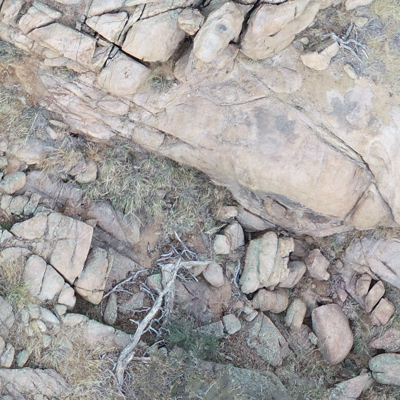

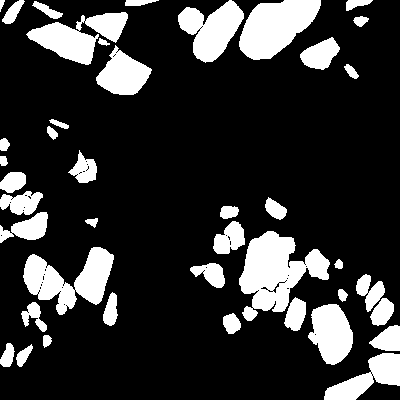

In [ ]:
id = 106
ellipse_data.show(id)
#ellipse_data.show_bbox(id)
#ellipse_data.show_overlay(103)
ellipse_data.show_overlay(id, random_color=False, bbox=False)

data/random_generation/split/1_0.pickle
data/random_generation/split/0_1.pickle
data/random_generation/split/0_0.pickle
data/random_generation/split/2_0.pickle
data/random_generation/split/2_1.pickle
data/random_generation/split/0_2.pickle
data/random_generation/split/0_3.pickle
data/random_generation/split/1_1.pickle
data/random_generation/split/2_2.pickle
data/random_generation/split/3_1.pickle
data/random_generation/split/3_2.pickle
data/random_generation/split/1_2.pickle
data/random_generation/split/2_3.pickle
data/random_generation/split/1_3.pickle
data/random_generation/split/3_0.pickle
data/random_generation/split/3_3.pickle
